In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense,  LSTM
from keras import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

2023-10-25 20:34:09.823835: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-25 20:34:09.925077: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-25 20:34:09.926684: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 20:34:11.720791: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df_ph = pd.read_csv('Dataset/Ph.csv')
df_kelembapan = pd.read_csv('Dataset/kelembapan.csv')
df_yield = pd.read_csv('Dataset/Hasil Panen OKE sip.csv')
df_hujan = pd.read_csv('Dataset/curah hujan.csv')
df_temp = pd.read_csv('Dataset/suhu tanah.csv')
df_jarak = pd.read_csv('Dataset/jarak tanaman.csv')

In [3]:
## Data Jarak Tanaman
df_jarak.dropna(axis=0, inplace=True)
df_jarak.to_csv('jarak.csv', index=False)
df_jarak_baru = pd.read_csv('jarak.csv')
df_jarak.info()

## Data PH
df_ph.dropna(axis=0, inplace=True)
df_ph.to_csv('ph.csv', index=False)
df_ph_baru = pd.read_csv('ph.csv')
df_ph_baru.info()

## Data Kelembapan
df_kelembapan.dropna(axis=0, inplace=True)
df_kelembapan.to_csv('kelembapan.csv', index=False)
df_kelembapan_baru = pd.read_csv('kelembapan.csv')
df_kelembapan_baru.info()

## Data Suhu Tanah
df_temp.dropna(axis=0, inplace=True)
df_temp.to_csv('tempe.csv', index=False)
df_temp_baru = pd.read_csv('tempe.csv')
df_temp_baru.info()

## Data Curah Hujan
df_hujan.dropna(axis=0, inplace=True)
df_hujan.to_csv('udan.csv', index=False)
df_hujan_baru = pd.read_csv('udan.csv')
df_hujan_baru.info()

## Data Yield
df_yield.dropna(axis=0, inplace=True)
df_yield.to_csv('panen.csv', index=False)
df_panen_baru = pd.read_csv('panen.csv')
df_panen_baru['Produksi Padi (ton/gkg)'] = pd.to_numeric(df_panen_baru['Produksi Padi (ton/gkg)'],errors='coerce')
df_panen_baru = df_panen_baru.loc[:, ~df_panen_baru.columns.str.contains('^Unnamed')]
df_panen_baru.info()
# df_panen_baru

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Tahun                     60 non-null     int64 
 1   Bulan                     60 non-null     object
 2   jarak antar tanaman (cm)  60 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tahun   60 non-null     int64  
 1   Bulan   60 non-null     object 
 2   ph      60 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Tahun           60 non-null     in

In [4]:
## Merge
hujan_temp_df = pd.merge(df_hujan_baru, df_temp_baru, on=['Tahun', 'Bulan'])
hujan_temp_panen_df = pd.merge(hujan_temp_df, df_panen_baru, on=['Tahun', 'Bulan'])
hujan_temp_panen_kelembapan_df = pd.merge(hujan_temp_panen_df, df_kelembapan_baru, on=['Tahun', 'Bulan'])
hujan_temp_panen_kelembapan_jarak_df = pd.merge(hujan_temp_panen_kelembapan_df, df_jarak_baru, on=['Tahun', 'Bulan'])
hujan_temp_panen_kelembapan_jarak_ph_df = pd.merge(hujan_temp_panen_kelembapan_jarak_df, df_ph_baru, on=['Tahun', 'Bulan'])
data = hujan_temp_panen_kelembapan_jarak_ph_df[['Tahun', 'Bulan', 'curah hujan (mm)', 'suhu tanah', 'ph', 'Kelembapan (%)', 'jarak antar tanaman (cm)', 'Luas Lahan', 'Luas Panen (ha)', 'Produksi Padi (ton/gkg)']]
data

,Tahun,Bulan,curah hujan (mm),suhu tanah,ph,Kelembapan (%),jarak antar tanaman (cm),Luas Lahan,Luas Panen (ha),Produksi Padi (ton/gkg)
0,2018,Februari,273.90,28.40,5.9,75,24,43573.0,16598.03,102755.27
1,2018,Maret,250.60,30.50,5.5,45,24,43573.0,9352.41,57899.01
2,2018,April,177.30,29.08,5.1,72,24,43573.0,2512.02,15551.44
3,2018,Mei,41.30,28.28,6.4,46,24,43573.0,9882.90,57103.19
4,2018,Juni,0.00,30.40,5.1,43,24,43573.0,7680.37,44377.02
5,2018,Juli,0.00,30.30,5.9,49,24,43573.0,3594.00,20766.00
6,2018,Agustus,0.00,30.82,5.5,64,24,43573.0,1793.23,10361.25
7,2018,September,133.30,28.90,5.1,55,24,43573.0,2663.34,18230.62
8,2018,Oktober,142.00,28.40,5.9,75,24,43573.0,1703.87,11663.03
9,2018,November,317.10,30.50,5.5,45,24,43573.0,925.73,6336.64


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tahun                     59 non-null     int64  
 1   Bulan                     59 non-null     object 
 2   curah hujan (mm)          59 non-null     float64
 3   suhu tanah                59 non-null     float64
 4   ph                        59 non-null     float64
 5   Kelembapan (%)            59 non-null     int64  
 6   jarak antar tanaman (cm)  59 non-null     int64  
 7   Luas Lahan                59 non-null     float64
 8   Luas Panen (ha)           59 non-null     float64
 9   Produksi Padi (ton/gkg)   59 non-null     float64
dtypes: float64(6), int64(3), object(1)
memory usage: 4.7+ KB


In [6]:
data.describe()

,Tahun,curah hujan (mm),suhu tanah,ph,Kelembapan (%),jarak antar tanaman (cm),Luas Lahan,Luas Panen (ha),Produksi Padi (ton/gkg)
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.0,59.000000,59.000000,59.000000
mean,2020.033898,202.295254,29.571864,5.574576,56.525424,24.0,39471.074576,5183.681695,31829.512712
std,1.413800,170.362961,0.965545,0.456219,12.154687,0.0,2430.051150,5494.890921,34200.862154
min,2018.000000,0.000000,28.280000,5.100000,43.000000,24.0,37637.400000,47.200000,268.360000
25%,2019.000000,72.415000,28.650000,5.100000,45.500000,24.0,37637.400000,1622.680000,9256.515000
50%,2020.000000,169.000000,29.080000,5.500000,55.000000,24.0,37637.400000,2514.400000,15551.440000
75%,2021.000000,297.400000,30.450000,5.900000,72.000000,24.0,41212.000000,6596.640000,39710.810000
max,2022.000000,732.700000,30.820000,6.400000,75.000000,24.0,43573.000000,21148.740000,125024.390000


In [7]:
data.shape
#X= 59 -> input
#y= 10 -> fitur/parameter

(59, 10)

In [8]:
## Parameter/Fitur
X = data[['curah hujan (mm)', 'suhu tanah', 'ph', 'Kelembapan (%)', 'jarak antar tanaman (cm)', 'Luas Lahan']]
## Target
y = data['Produksi Padi (ton/gkg)']

In [9]:
columns_to_drop = ['curah hujan (mm)', 'suhu tanah', 'ph', 'Kelembapan (%)', 'jarak antar tanaman (cm)']
data = data.drop(columns_to_drop, axis=1)  # axis=1 mengindikasikan bahwa yang dihapus adalah kolom, bukan baris
print(data)

    Tahun      Bulan  Luas Lahan  Luas Panen (ha)  Produksi Padi (ton/gkg)
0    2018   Februari     43573.0         16598.03                102755.27
1    2018      Maret     43573.0          9352.41                 57899.01
2    2018      April     43573.0          2512.02                 15551.44
3    2018        Mei     43573.0          9882.90                 57103.19
4    2018       Juni     43573.0          7680.37                 44377.02
5    2018       Juli     43573.0          3594.00                 20766.00
6    2018    Agustus     43573.0          1793.23                 10361.25
7    2018  September     43573.0          2663.34                 18230.62
8    2018    Oktober     43573.0          1703.87                 11663.03
9    2018   November     43573.0           925.73                  6336.64
10   2018   Desember     43573.0           566.50                  3877.70
11   2019    Januari     41212.0          1069.39                  6321.88
12   2019   Februari     

# OneHot Encoder

In [10]:
from sklearn.preprocessing import OneHotEncoder
df_onehot = pd.get_dummies(data, columns=['Tahun', 'Bulan'], prefix=['Tahun', 'Bulan'])
data = df_onehot.loc[:, df_onehot.columns != 'Produksi Padi (ton/gkg)']
data['Produksi Padi (ton/gkg)'] = df_onehot['Produksi Padi (ton/gkg)']

In [11]:
data

,Luas Lahan,Luas Panen (ha),Tahun_2018,Tahun_2019,Tahun_2020,Tahun_2021,Tahun_2022,Bulan_Agustus,Bulan_April,Bulan_Desember,Bulan_Februari,Bulan_Januari,Bulan_Juli,Bulan_Juni,Bulan_Maret,Bulan_Mei,Bulan_November,Bulan_Oktober,Bulan_September,Produksi Padi (ton/gkg)
0,43573.0,16598.03,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,102755.27
1,43573.0,9352.41,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,57899.01
2,43573.0,2512.02,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,15551.44
3,43573.0,9882.90,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,57103.19
4,43573.0,7680.37,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,44377.02
5,43573.0,3594.00,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,20766.00
6,43573.0,1793.23,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,10361.25
7,43573.0,2663.34,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,18230.62
8,43573.0,1703.87,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,11663.03
9,43573.0,925.73,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,6336.64


In [12]:
data['Produksi Padi (ton/gkg)'].values

array([102755.27,  57899.01,  15551.44,  57103.19,  44377.02,  20766.  ,
        10361.25,  18230.62,  11663.03,   6336.64,   3877.7 ,   6321.88,
        25468.78, 125024.39,  13865.17,  16753.4 ,  80513.07,  40806.57,
        14270.22,  14105.22,  12496.56,  14245.9 ,   3846.5 ,   6451.09,
        33654.14, 110293.75,  63451.68,   6057.83,  30704.71,  90408.2 ,
        21227.7 ,  18754.71,  13395.53,  13048.93,    268.36,   2514.4 ,
        38615.05,  90703.72,  23672.07,   5377.67,  95596.82,  37155.99,
        12286.86,   3529.16,  20564.27,  10208.79,   2118.79,    618.63,
       102194.51,  90703.72,  13965.33,  14177.11, 107551.27,  27669.02,
        14655.14,   6836.77,  22863.35,   8304.24,   1703.11])

<Axes: >

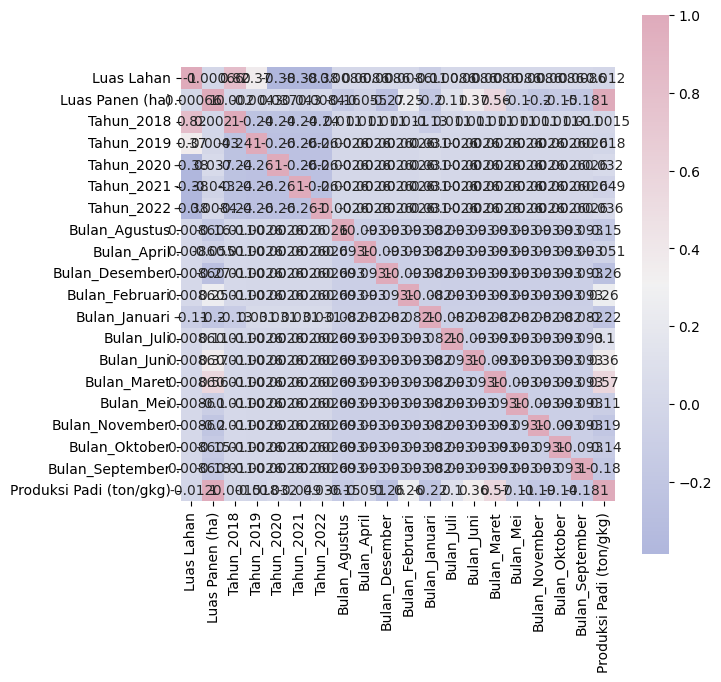

In [13]:
corrmat = data.corr(method='pearson')
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(7,7))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)

In [14]:
hist_window = 2
horizon = 5

In [15]:
int(y.shape[0]/horizon)

11

In [16]:
def deret_waktu_regresi(dataset, target, start, end, window, horizon):
  X = []
  y = []
  start = start + window
  if end is None:
    end = len(dataset) - horizon

  for i in range(start, end):
    indices = range(i-window, i)
    X.append(dataset[indices])

    #indicey = range(i+1, i+1+horizon)
    indicey = range(i, i+horizon)
    y.append(target[indicey])

  return np.array(X), np.array(y)

In [17]:
indices = range(1, 5)
X.values[indices]

array([[2.5060e+02, 3.0500e+01, 5.5000e+00, 4.5000e+01, 2.4000e+01,
        4.3573e+04],
       [1.7730e+02, 2.9080e+01, 5.1000e+00, 7.2000e+01, 2.4000e+01,
        4.3573e+04],
       [4.1300e+01, 2.8280e+01, 6.4000e+00, 4.6000e+01, 2.4000e+01,
        4.3573e+04],
       [0.0000e+00, 3.0400e+01, 5.1000e+00, 4.3000e+01, 2.4000e+01,
        4.3573e+04]])

In [18]:
indices = range(1, 5)
X.iloc[indices, :]

,curah hujan (mm),suhu tanah,ph,Kelembapan (%),jarak antar tanaman (cm),Luas Lahan
1,250.6,30.50,5.5,45,24,43573.0
2,177.3,29.08,5.1,72,24,43573.0
3,41.3,28.28,6.4,46,24,43573.0
4,0.0,30.40,5.1,43,24,43573.0


In [19]:
n = int(y.shape[0]/horizon)
TRAIN_SPLIT = int(len(data)*.8)

x_train_multi, y_train_multi = deret_waktu_regresi(X.values, y.values, 0, TRAIN_SPLIT, hist_window, horizon)

In [20]:
n = int(y.shape[0]/horizon)
TRAIN_SPLIT = int(len(data)*.8)

x_train_multi, y_train_multi = deret_waktu_regresi(
    X.values, y.values, 0, TRAIN_SPLIT, hist_window, horizon)
x_test_multi, y_test_multi = deret_waktu_regresi(
    X.values, y.values, TRAIN_SPLIT, None, hist_window, horizon)

In [26]:
x_train_multi, y_train_multi

(array([[[2.73900e+02, 2.84000e+01, 5.90000e+00, 7.50000e+01,
          2.40000e+01, 4.35730e+04],
         [2.50600e+02, 3.05000e+01, 5.50000e+00, 4.50000e+01,
          2.40000e+01, 4.35730e+04]],
 
        [[2.50600e+02, 3.05000e+01, 5.50000e+00, 4.50000e+01,
          2.40000e+01, 4.35730e+04],
         [1.77300e+02, 2.90800e+01, 5.10000e+00, 7.20000e+01,
          2.40000e+01, 4.35730e+04]],
 
        [[1.77300e+02, 2.90800e+01, 5.10000e+00, 7.20000e+01,
          2.40000e+01, 4.35730e+04],
         [4.13000e+01, 2.82800e+01, 6.40000e+00, 4.60000e+01,
          2.40000e+01, 4.35730e+04]],
 
        [[4.13000e+01, 2.82800e+01, 6.40000e+00, 4.60000e+01,
          2.40000e+01, 4.35730e+04],
         [0.00000e+00, 3.04000e+01, 5.10000e+00, 4.30000e+01,
          2.40000e+01, 4.35730e+04]],
 
        [[0.00000e+00, 3.04000e+01, 5.10000e+00, 4.30000e+01,
          2.40000e+01, 4.35730e+04],
         [0.00000e+00, 3.03000e+01, 5.90000e+00, 4.90000e+01,
          2.40000e+01, 4.35730e+04]

In [27]:
x_test_multi, y_test_multi

(array([[[2.13000e+02, 2.89000e+01, 5.10000e+00, 5.50000e+01,
          2.40000e+01, 3.76374e+04],
         [2.96000e+02, 2.84000e+01, 5.90000e+00, 7.50000e+01,
          2.40000e+01, 3.76374e+04]],
 
        [[2.96000e+02, 2.84000e+01, 5.90000e+00, 7.50000e+01,
          2.40000e+01, 3.76374e+04],
         [2.32000e+02, 3.05000e+01, 5.50000e+00, 4.50000e+01,
          2.40000e+01, 3.76374e+04]],
 
        [[2.32000e+02, 3.05000e+01, 5.50000e+00, 4.50000e+01,
          2.40000e+01, 3.76374e+04],
         [1.69000e+02, 2.90800e+01, 5.10000e+00, 7.20000e+01,
          2.40000e+01, 3.76374e+04]],
 
        [[1.69000e+02, 2.90800e+01, 5.10000e+00, 7.20000e+01,
          2.40000e+01, 3.76374e+04],
         [1.34000e+02, 2.82800e+01, 6.40000e+00, 4.60000e+01,
          2.40000e+01, 3.76374e+04]],
 
        [[1.34000e+02, 2.82800e+01, 6.40000e+00, 4.60000e+01,
          2.40000e+01, 3.76374e+04],
         [3.19000e+02, 3.04000e+01, 5.10000e+00, 4.30000e+01,
          2.40000e+01, 3.76374e+04]

# Prediksi SVM

In [24]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

svr = SVR(kernel='linear', C=1000)
svr.fit(X_train, y_train)

y_pred = svr.predict(X_test)

# Evaluasi model
mse = mean_squared_error(y_test, y_pred)

mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"r2 Score: {r2}")
print(y_pred)

NameError: name 'X_train' is not defined

## Plot Hasil SVM

In [ ]:
# Plot data aktual
plt.scatter(range(len(y_test)), y_test, color='b', label='Data Aktual', marker='o')

# Plot data yang diprediksi
plt.scatter(range(len(y_pred)), y_pred, color='r', label='Data Prediksi', marker='x')

plt.xlabel('Data Poin')
plt.ylabel('Produksi Padi (ton/gkg)')

plt.title('Perbandingan Data Aktual dan Data yang Diprediksi')
plt.legend()
plt.show()


In [ ]:
y_test

In [ ]:
y_pred

In [ ]:
# Create a DataFrame to store the results
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Save the results to a CSV file
results.to_csv('Hasil Prediksi SVM.csv', index=False)

In [ ]:
# Buat array indeks untuk sumbu x
x = np.arange(len(y_test))

# Plot data aktual
plt.plot(x, y_test, label='Data Aktual', marker='o')

# Plot data yang diprediksi
plt.plot(x, y_pred, label='Data Prediksi', marker='x')

plt.xlabel('Data Poin')
plt.ylabel('Produksi Padi (ton/gkg)')
plt.title('Perbandingan Data Aktual dan Data yang Diprediksi')
plt.legend()
plt.show()